In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!mkdir speech_data
%cd speech_data
!mkdir model_weights 

/content/speech_data


In [0]:
labels = ['up', 'three', 'four', 'stop', 'left', 'on', 'six', 'right', 'go', 'seven', 'no', 'one', 'off', 'yes', 'nine', 'zero', 'two', 'down', 'five', 'eight']


In [5]:

from shutil import copyfile

for label in labels:
  copyfile('/content/drive/My Drive/cs419_data/'+label+'.mat','/content/speech_data/'+label+'.mat')

!ls

down.mat   four.mat  model_weights  off.mat  right.mat	stop.mat   up.mat
eight.mat  go.mat    nine.mat	    one.mat  seven.mat	three.mat  yes.mat
five.mat   left.mat  no.mat	    on.mat   six.mat	two.mat    zero.mat


In [6]:
import scipy.io as sio
import numpy as np

x = np.arange(8000)
y = []
for label in labels:
  print(label)
  m = sio.loadmat(label+'.mat')
  m = m['samples']
  x = np.vstack((x,m))
  y = y + [label]*m.shape[0]
  #print(m.shape[0])
  #print("----")

#Delete the initial row
x = np.delete(x,0,axis = 0)

up
three
four
stop
left
on
six
right
go
seven
no
one
off
yes
nine
zero
two
down
five
eight


In [7]:
from sklearn.preprocessing import OneHotEncoder

y_array = np.array(y).reshape(-1,1)

ohe = OneHotEncoder()
ohe.fit(y_array)
y_enc = ohe.transform(y_array).toarray()
print(y_enc)

#To get inverse mapping, use
#z = np.zeros((1,20))
#[0,-3] =1 
#print(ohe.inverse_transform(z)[0,0])

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [8]:
from sklearn.model_selection import train_test_split

x1,x_test,y1,y_test = train_test_split(x,y_enc,test_size=0.2,random_state=12,shuffle = True)
x_train,x_val,y_train,y_val = train_test_split(x1,y1,test_size=0.25,random_state=12,shuffle = True)

print(x_test.shape)
print(y_test.shape)

print(x_val.shape)
print(y_val.shape)

print(x_train.shape)
print(y_train.shape)

#8575 Test
#8575 Val
#25724 Train

(8575, 8000)
(8575, 20)
(8575, 8000)
(8575, 20)
(25724, 8000)
(25724, 20)


In [9]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

NUM_EPOCHS = 10
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 3

model = Sequential()
model.add(Dense(20, input_dim=8000, activation='softmax'))

adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= adm , metrics=['accuracy'])
model.summary()

name = "model_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = name, monitor = 'val_acc', save_best_only = True, mode = 'auto')

fit_hist = model.fit(x = x_train, 
          y = y_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data=(x_val,y_val),
          callbacks=[checkpointer, early_stopper])

score = model.evaluate(x_test, y_test,batch_size=BATCH_SIZE,verbose=1)

print("____TEST SET SCORES_____")
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))


Using TensorFlow backend.









Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                160020    
Total params: 160,020
Trainable params: 160,020
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 25724 samples, validate on 8575 samples
Epoch 1/10





25724/25724 [==============================] - 14s 546us/step - loss: 3.0313 - acc: 0.0621 - val_loss: 3.0410 - val_acc: 0.0813
Epoch 2/10
25724/25724 [==============================] - 5s 175us/step - loss: 2.7752 - acc: 0.1903 - val_loss: 3.1060 - val_acc: 0.0854
Epoch 3/10
25724/25724 [==============================] - 5s 176us/step - loss: 2.6386 - acc: 0.2405 - val_loss: 3.1803 - val_acc: 0.0810
Epoch 4/10
25724/25724 [==============================] - 5s 185us/st

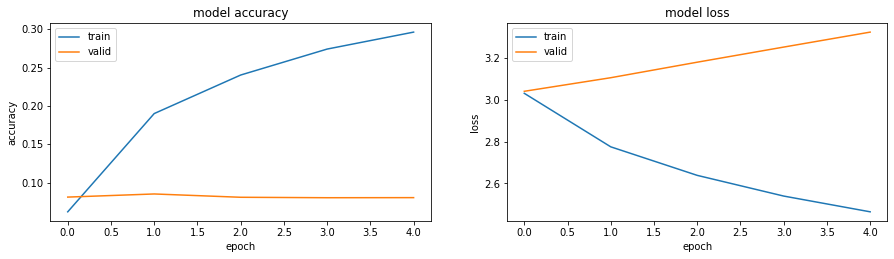

In [10]:
import matplotlib.pyplot as plt
#print(fit_hist.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['acc'])  
plt.plot(fit_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

8575/8575 [==============================] - 1s 82us/step


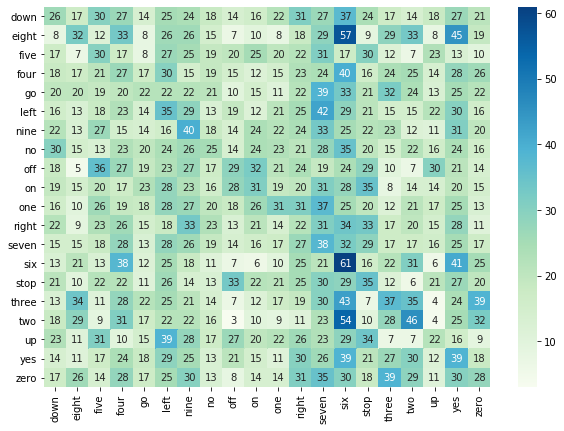

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

from keras.utils.np_utils import to_categorical   

y_pred = model.predict(x_test,batch_size=BATCH_SIZE,verbose=1)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix, index = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))],
                  columns = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='GnBu')


## Now, let's improve the model by adding more dense layers.

In [12]:
K.clear_session()

NUM_EPOCHS = 10
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 3

model = Sequential()
model.add(Dense(128, input_dim=8000, activation='relu'))
model.add(Dense(20, activation='softmax'))

adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= adm , metrics=['accuracy'])
model.summary()

name = "model_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = name, monitor = 'val_acc', save_best_only = True, mode = 'auto')

fit_hist = model.fit(x = x_train, 
          y = y_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data=(x_val,y_val),
          callbacks=[checkpointer, early_stopper])

score = model.evaluate(x_test, y_test,batch_size=BATCH_SIZE,verbose=1)

print("____TEST SET SCORES_____")
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024128   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 1,026,708
Trainable params: 1,026,708
Non-trainable params: 0
_________________________________________________________________
Train on 25724 samples, validate on 8575 samples
Epoch 1/10
25724/25724 [==============================] - 6s 217us/step - loss: 3.0072 - acc: 0.0723 - val_loss: 2.9777 - val_acc: 0.0942
Epoch 2/10
25724/25724 [==============================] - 5s 210us/step - loss: 2.5738 - acc: 0.2514 - val_loss: 3.1109 - val_acc: 0.0992
Epoch 3/10
25724/25724 [==============================] - 5s 205us/step - loss: 2.1089 - acc: 0.3938 - val_loss: 3.3519 - val_acc: 0.1038
Epoch 4/10
25724/25724 [===================

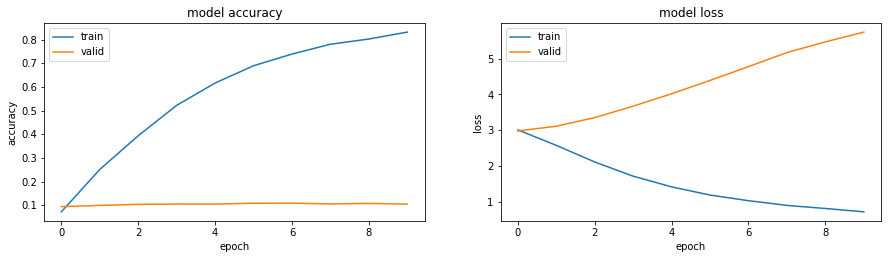

In [13]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['acc'])  
plt.plot(fit_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

8575/8575 [==============================] - 1s 83us/step


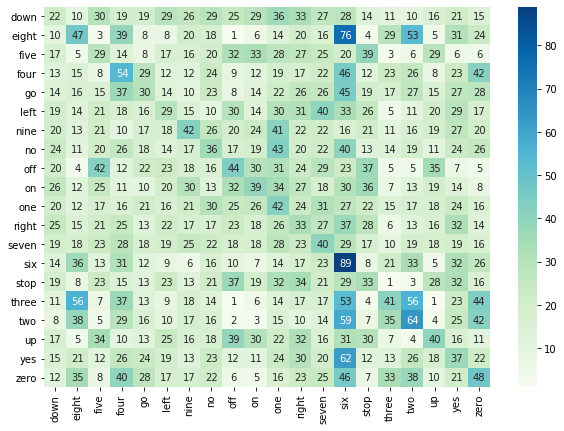

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

from keras.utils.np_utils import to_categorical   

y_pred = model.predict(x_test,batch_size=BATCH_SIZE,verbose=1)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix, index = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))],
                  columns = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='GnBu')

Clearly, even this model is not that great. Simple dense layers are simply not good enough since we are not using the spacial correlation of speech data nor do we have enough data for a large dense network. <br>
Now, let's look at some better architectures.

In [31]:
from keras.layers import Dropout
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Flatten

K.clear_session()

NUM_EPOCHS = 40
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 3

model = Sequential()
model.add(Conv1D(64, 8, activation='relu', input_shape=(8000,1)))  #8000-7 = 7993
model.add(Conv1D(64, 8, activation='relu')) #7986
model.add(MaxPooling1D(3))  #2662
model.add(Conv1D(128, 3, activation='relu')) #2660
model.add(GlobalAveragePooling1D()) #65536
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(20, activation='softmax'))


adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= adm , metrics=['accuracy'])
model.summary()

name = "model_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = name, monitor = 'val_acc', save_best_only = True, mode = 'auto')

x_train = x_train.reshape(-1,8000,1)
x_val = x_val.reshape(-1,8000,1)
x_test = x_test.reshape(-1,8000,1)
fit_hist = model.fit(x = x_train, 
          y = y_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data=(x_val,y_val),
          callbacks=[checkpointer, early_stopper])

score = model.evaluate(x_test, y_test,batch_size=BATCH_SIZE,verbose=1)

print("____TEST SET SCORES_____")
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7993, 64)          576       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7986, 64)          32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2660, 128)         24704     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)               

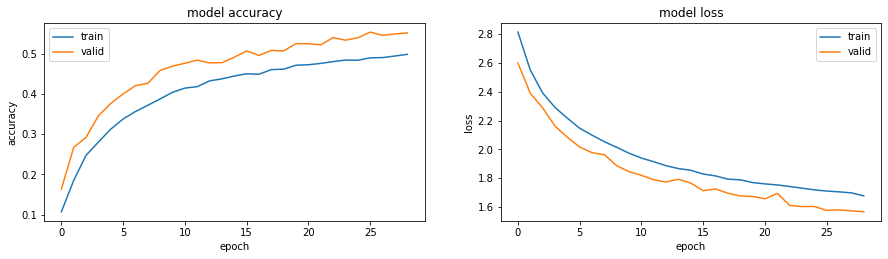

8575/8575 [==============================] - 2s 264us/step


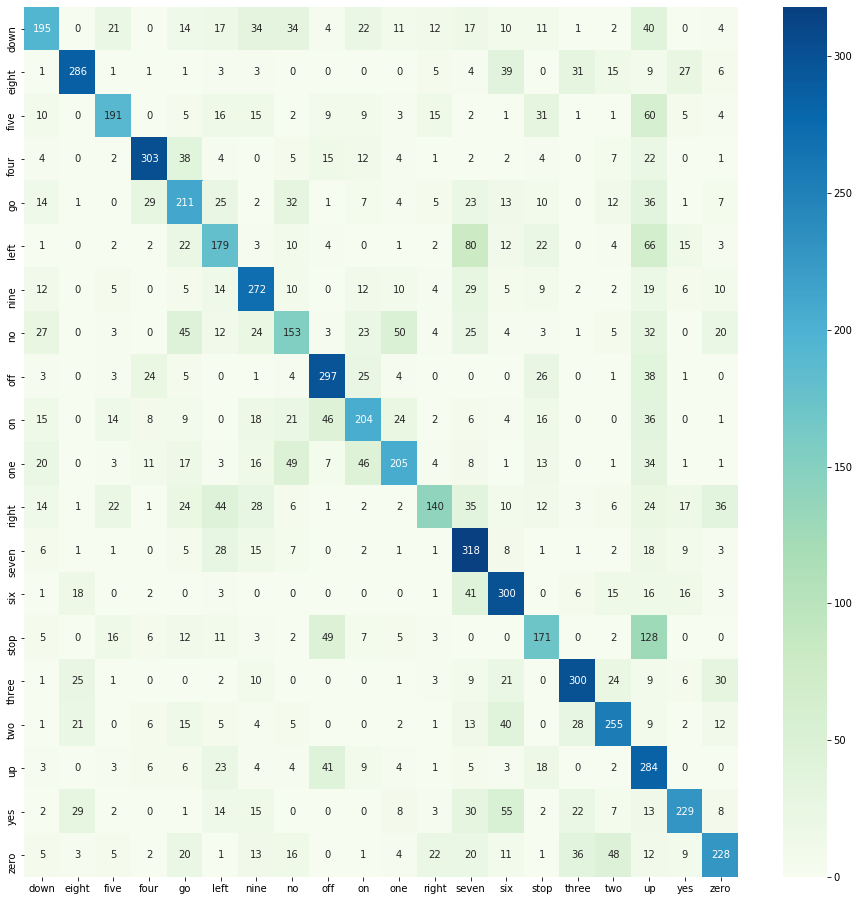

In [33]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['acc'])  
plt.plot(fit_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


y_pred = model.predict(x_test,batch_size=BATCH_SIZE,verbose=1)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix, index = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))],
                  columns = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=True,cmap='GnBu',fmt='d')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7998, 32)          128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7996, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3998, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3998, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3996, 64)          6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3994, 64)          12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1997, 64)         

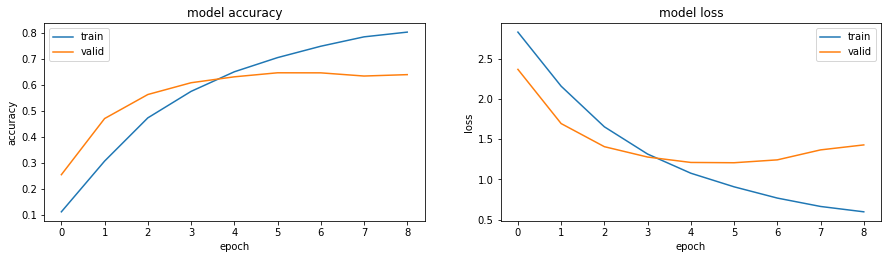

8575/8575 [==============================] - 2s 243us/step


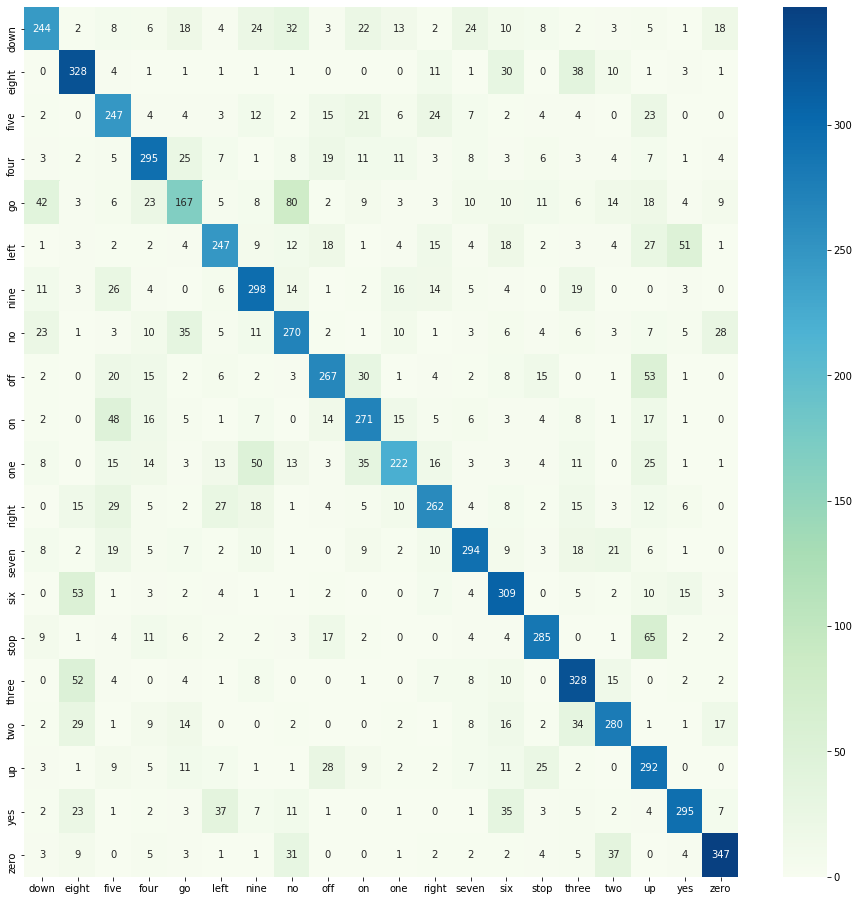

In [35]:
from keras.layers import Dropout
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Flatten

K.clear_session()

NUM_EPOCHS = 11
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 3

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(8000,1)))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= adm , metrics=['accuracy'])
model.summary()

name = "model_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = name, monitor = 'val_acc', save_best_only = True, mode = 'auto')

#x_train = x_train.reshape(-1,8000,1)
#x_val = x_val.reshape(-1,8000,1)
#x_test = x_test.reshape(-1,8000,1)

fit_hist = model.fit(x = x_train, 
          y = y_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data=(x_val,y_val),
          callbacks=[checkpointer, early_stopper])

score = model.evaluate(x_test, y_test,batch_size=BATCH_SIZE,verbose=1)

print("____TEST SET SCORES_____")
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['acc'])  
plt.plot(fit_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


y_pred = model.predict(x_test,batch_size=BATCH_SIZE,verbose=1)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix, index = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))],
                  columns = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=True,cmap='GnBu',fmt='d')
